In [67]:
import time
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import seaborn as sns
import math
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression, Perceptron, SGDClassifier
import ipympl
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, f1_score, precision_recall_curve, average_precision_score, roc_curve, auc
%matplotlib widget
import warnings
warnings.filterwarnings('ignore')

### CARREGUEM EL DATASET

In [68]:
def load_dataset(path):
    d_train = pd.read_csv(path, header=0, delimiter=',')
    return d_train

os.getcwd()
path = 'C:/Users/julia/Documents/JULIA/UNI/3r/kaggle/train_gr'
os.chdir(path)
os.getcwd()
d_train = load_dataset('train.csv')
d_overview = load_dataset('game_overview.csv')

os.getcwd()
path = 'C:/Users/julia/Documents/JULIA/UNI/3r/kaggle/test_gr'
os.chdir(path)
os.getcwd()
d_test = load_dataset('test.csv')

### 1. EDA


El dataset utilitza dades de valoracions de videojocs fetes per usuaris en la plataforma Steam.

Tenim 4 atributs:
- El nom del videojoc
- L'any de la valoració
- El comentari que van fer per valorar el videojoc 
- Un boolea que diu si l'usuari recomana el videojoc (1) o sino el recomana (0)

L'objecitu és predir si l'usuari recomana o no el videojoc a partir del comentari i d'altres atributs.

In [69]:
print("Dimensionalitat de la BBDD train:", d_train.shape)
print("Dimensionalitat de la BBDD test:", d_test.shape)
print("Nombre de valors no existents:")
print(d_train.isnull().sum())
print(d_test.isnull().sum())

Dimensionalitat de la BBDD train: (17494, 5)
Dimensionalitat de la BBDD test: (8045, 4)
Nombre de valors no existents:
review_id            0
title                0
year               178
user_review          0
user_suggestion      0
dtype: int64
review_id       0
title           0
year           67
user_review     0
dtype: int64


#### Observem que només tenim valors inexistents a la variable de l'any.
#### La variable review_id l'eliminarem perquè només és un índex i no ens aporta informació.
#### Crearem una nova variable que ens diu quantes paraules té cada review.
#### Crearem una nova variable que contingui la informació de title, year i review de forma concatenada. (ens serà útil per quan fem el train amb diferents models).

In [70]:
d_train.insert(3, 'words', d_train["user_review"].apply(lambda s: len(s.split())))
d_train = d_train.drop(['review_id'], axis=1)
d_train['title'] = [s.replace(" ", "") for s in d_train['title']]
d_train.insert(2, 'year_s', [str(s) for s in d_train['year']])
d_train.insert(0, 'title_year_review', d_train['title'] + " " + d_train['year_s'] + " " + d_train["user_review"])

d_test.insert(3, 'words', d_test["user_review"].apply(lambda s: len(s.split())))
d_test = d_test.drop(['review_id'], axis=1)
d_test['title'] = [s.replace(" ", "") for s in d_test['title']]
d_test.insert(2, 'year_s', [str(s) for s in d_test['year']])
d_test.insert(0, 'title_year_review', d_test['title'] + " " + d_test['year_s'] + " " + d_test["user_review"])

In [71]:
d_train.head() 

,title_year_review,title,year,year_s,words,user_review,user_suggestion
0,Spooky'sJumpScareMansion 2016.0 I'm scared and...,Spooky'sJumpScareMansion,2016.0,2016.0,132,I'm scared and hearing creepy voices. So I'll...,1
1,"Spooky'sJumpScareMansion 2016.0 Best game, mor...",Spooky'sJumpScareMansion,2016.0,2016.0,44,"Best game, more better than Sam Pepper's YouTu...",1
2,Spooky'sJumpScareMansion 2016.0 A littly iffy ...,Spooky'sJumpScareMansion,2016.0,2016.0,70,"A littly iffy on the controls, but once you kn...",1
3,"Spooky'sJumpScareMansion 2015.0 Great game, fu...",Spooky'sJumpScareMansion,2015.0,2015.0,47,"Great game, fun and colorful and all that.A si...",1
4,Spooky'sJumpScareMansion 2015.0 Not many games...,Spooky'sJumpScareMansion,2015.0,2015.0,67,Not many games have the cute tag right next to...,1


#### A continuació veiem les correlacions entre els atributs numèrics. Veiem que entre l'atribut objectiu (suggestion) i els altres dos stributs (letters i year) i ha una correlació bastant petita.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
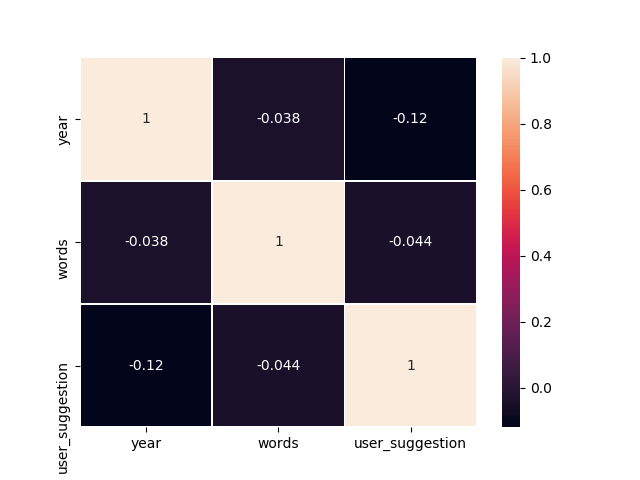

In [72]:
plt.figure()
ax = sns.heatmap(d_train.corr(), annot=True, linewidths=.5)

#### Veiem que hi ha més recomanacions positives (1), que recomenacions negatives (0).

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
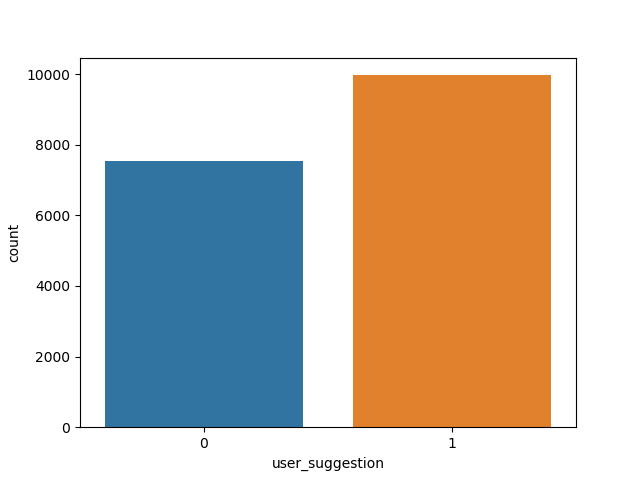

In [73]:
plt.figure()
sns.countplot(d_train["user_suggestion"])
plt.show()

#### Separem l'atribut objectiu (y) que és l'atribut que ens diu si l'usuari recomana o no el videojoc. El voldrem predir a partir de l'atribut que hem creat que conté el nom del videojoc, l'any i el comentari.

In [74]:
data = d_train.values
X_train = data[:, 0]
y_train = data[:, len(d_train.columns)-1]
y_train = y_train.astype('int')

data = d_test.values
X_test = data[:, 0]

### 2. Creem un model

#### Separem les dades en entranament i validació

In [79]:
x_t, x_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
vectorizer = CountVectorizer()

#### Provarem diferents models per veure quin és el que té millor score.

In [111]:
names = [
    "SGDClassifier       ",
    "Logistic Regression ",
    "Perceptron          ",
    "ComplementNB        ",
    "MultinomialNB       ",
    "Nearest Neighbors   ",
    "Decision Tree       ",
    "Random Forest       ",
    "Bagging             ",
    "AdaBoost            "
]
classifiers = [
    SGDClassifier(penalty='l2', alpha=0.0001, max_iter=91, tol=0.01, shuffle=False),
    LogisticRegression(C=12.0, fit_intercept=True, penalty='l2', tol=0.1),
    Perceptron(tol=0.005, random_state=0),
    ComplementNB(),
    MultinomialNB(alpha=1.0),
    KNeighborsClassifier(6),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    BaggingClassifier(KNeighborsClassifier(n_neighbors=3), max_samples=0.5, max_features=0.5),
    AdaBoostClassifier(n_estimators=10)
]

In [112]:
print("Mètode                   Temps   Score")
for i in range(len(classifiers)):
    clf = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                    ('clf', classifiers[i])])
    inici = time.time()
    clf = clf.fit(x_t, y_t)
    fi = time.time()
    print("| " + names[i] + " | " + str(round(fi-inici, 2))+ "s |  " + str(round(100*clf.score(x_v, y_v),1))+" % |")

Mètode                   Temps   Score
| SGDClassifier        | 1.72s |  87.9 % |
| Logistic Regression  | 1.83s |  88.4 % |
| Perceptron           | 1.93s |  85.1 % |
| ComplementNB         | 1.78s |  83.0 % |
| MultinomialNB        | 1.65s |  78.8 % |
| Nearest Neighbors    | 1.53s |  74.7 % |
| Decision Tree        | 2.35s |  70.9 % |
| Random Forest        | 1.54s |  57.0 % |
| Bagging              | 1.94s |  56.4 % |
| AdaBoost             | 18.6s |  82.9 % |


#### Els mètodes que funcionen millor són SGDC i Logistic Regression així que buscarem els millors hiperparàmetres per veure si podem millor el resultat que tenim fins ara.

### 3. Busquem els millors hiperparàmetres 
#### SGDC

In [114]:
maxi = 0
l = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
for a in l:
    clf = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(penalty='l2', alpha=a, max_iter=94, tol=0.01, shuffle=False))])
    clf = clf.fit(x_t, y_t)
    m = clf.score(x_v, y_v)
    if (m > maxi):
        maxi = m
        a_max = a
print("Millor alpha:", a_max)
print("Score màxim: ", maxi)

Millor alpha: 0.0001
Score màxim:  0.879394112603601


In [87]:
maxi = 0
l = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
for tol in l:
    clf = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(penalty='l2', alpha=a_max, max_iter=94, tol=tol, shuffle=False))])
    clf = clf.fit(x_t, y_t)
    m = clf.score(x_v, y_v)
    if (m > maxi):
        maxi = m
        tol_max = tol
print("Millor tol:  ", tol_max)
print("Score màxim: ", maxi)

Millor tol:   0.05
Score màxim:  0.8813946841954844


In [88]:
maxi = 0
for i in range(90,110):
    clf = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(penalty='l2', alpha=a_max, max_iter=i, tol=tol_max, shuffle=False))])
    clf = clf.fit(x_t, y_t)
    m = clf.score(x_v, y_v)
    if (m > maxi):
        maxi = m
        i_max = i
print("Millor iter: ", i_max)
print("Score màxim: ", maxi)

Millor iter:  90
Score màxim:  0.8813946841954844


#### Regressor Logístic

In [108]:
maxi = 0
l = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
for c in range(3,15):
    clf = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=c, fit_intercept=True, penalty='l2', tol=0.1))])
    clf = clf.fit(x_t, y_t)
    m = clf.score(x_v, y_v)
    if (m > maxi):
        maxi = m
        c_max = c
print("Millor c:    ", c_max)
print("Score màxim: ", maxi)

Millor c:     4
Score màxim:  0.8888253786796227


In [90]:
folds = 5
maxi = 0
l = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
for t in l:
    clf = Pipeline([('vect', vectorizer), 
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=c_max, fit_intercept=True, penalty='l2', tol=t))])
    clf = clf.fit(x_t, y_t)
    m = clf.score(x_v, y_v)
    if (m > maxi):
        maxi = m
        t_max = t
print("Millor t:    ", t_max)
print("Score màxim: ", maxi)

Millor t:     0.1
Score màxim:  0.8888253786796227


### 4. Comprovem com funciona el model

In [115]:
#SGDClassifier
clf1 = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(penalty='l2', alpha=a_max, max_iter=i_max, tol=tol_max, shuffle=False))])
clf1.fit(x_t, y_t)
#Logistic Regression
clf2 = Pipeline([('vect', vectorizer), ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(C=c_max, fit_intercept=True, penalty='l2', tol=t_max))])
clf2.fit(x_t, y_t)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 LogisticRegression(C=4, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
    

#### Precision and Recall

In [92]:
def precision_recall_roc(probs):
    n_classes=2
    precision = {}
    recall = {}
    average_precision = {}
    plt.figure()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_v == i, probs[:, i])
        average_precision[i] = average_precision_score(y_v == i, probs[:, i])

        plt.plot(recall[i], precision[i],
        label='Precision-Recall curve class {0} (area = {1:0.2f})'
                               ''.format(i, average_precision[i]))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc="lower left")

    # Compute ROC curve and ROC area for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_v == i, probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area and Plot ROC curve
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
        plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
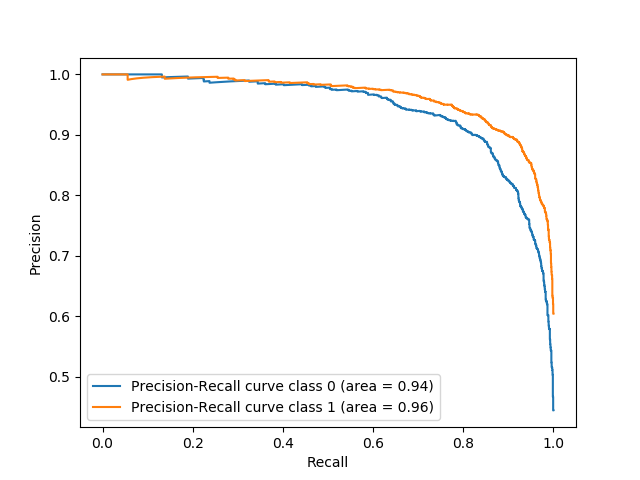

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
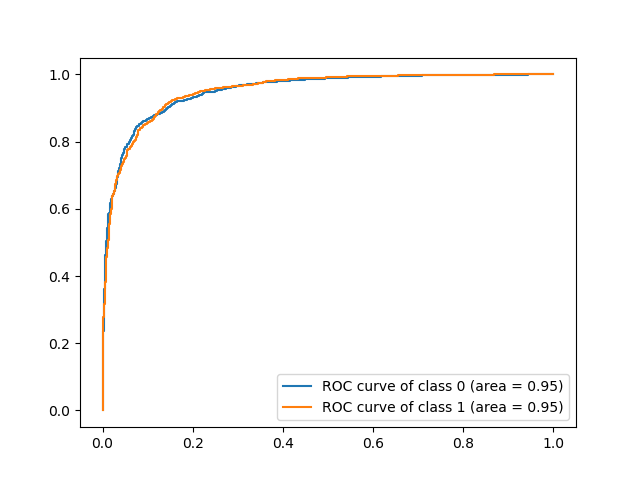

In [93]:
probs = clf2.predict_proba(x_v)
precision_recall_roc(probs)

#### Classification Report

In [116]:
y_pred=clf2.predict(x_v)
y_true = y_v
print(classification_report(y_true, y_pred, target_names=['class 0', 'class 1']))

              precision    recall  f1-score   support

     class 0       0.89      0.85      0.87      1505
     class 1       0.89      0.92      0.90      1994

    accuracy                           0.89      3499
   macro avg       0.89      0.88      0.89      3499
weighted avg       0.89      0.89      0.89      3499



#### Confusion Matrix

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
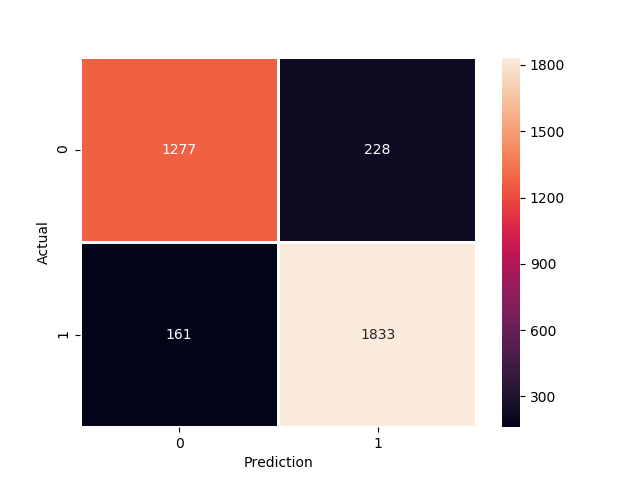

In [117]:
conf_matrix = confusion_matrix(y_pred=y_pred,y_true=y_true)
plt.subplots()
sns.heatmap(conf_matrix,annot=True,linewidths=1.5,fmt=".0f")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

### 5. Fem una predicció pel dataset test

In [118]:
predictions = clf2.predict(X_test)
print("Temps: " + str(fi-inici))
print(predictions)

Temps: 18.59577226638794
[1 0 0 ... 0 1 1]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
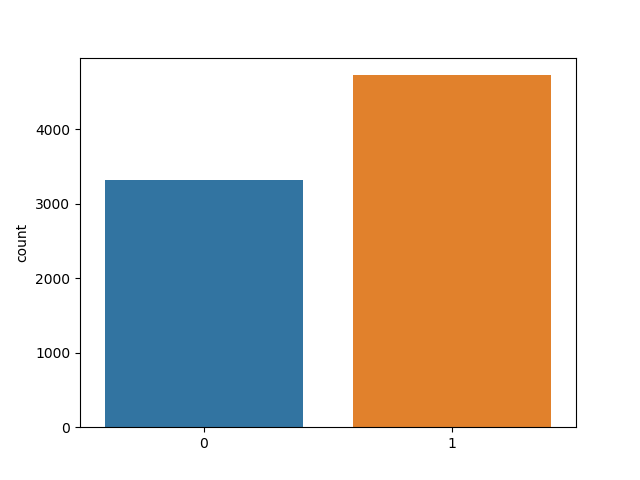

In [119]:
plt.figure()
sns.countplot(predictions)
plt.show()